In [17]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import requests
import numpy as np
from scipy import stats
import openmeteo_requests
import requests_cache
from datetime import datetime, timedelta
from retry_requests import retry
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = "browser"  # Opens the figure in a browser window
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [194]:
# Load the data
start_date = '2024-12-01'
today = datetime.now().date() - timedelta(days=1)
end_date = today.strftime('%Y-%m-%d')


url = f'http://209.38.208.230:8000/api/pvmeasurementdata/?start_date={start_date}&end_date={end_date}&ppe=590310600030911897'

# Get the data from the API
response = requests.get(url=url)

# Create a dataframe from the response

df_dam = pd.DataFrame(response.json())

# Clean the DataFrame
df_dam['production'] = df_dam['production'].replace(['-', 'n/e', 'N/A', 'NaN'], np.nan)
df_dam['production'] = df_dam['production'].astype(float)
df_dam['timestamp'] = pd.to_datetime(df_dam['timestamp'], errors='coerce', utc=True)
df_dam['timestamp'] = df_dam['timestamp'].dt.tz_convert('Europe/Warsaw')
df_dam['timestamp'] = df_dam['timestamp'].dt.tz_localize(None)  

if df_dam['timestamp'].isnull().any():
    print("Warning: Invalid timestamps detected. Dropping these rows.")
    combined_weather_and_df_dam = df_dam.dropna(subset=['timestamp'])

# drop all the columns instead of timestamp and production
df_dam = df_dam[['timestamp', 'production', 'latitude', 'longitude']]



In [195]:
print(df_dam.tail())

               timestamp  production latitude longitude
6428 2025-02-05 23:00:00         0.0  52.6395   16.6405
6429 2025-02-05 23:15:00         0.0  52.6395   16.6405
6430 2025-02-05 23:30:00         0.0  52.6395   16.6405
6431 2025-02-05 23:45:00         0.0  52.6395   16.6405
6432 2025-02-06 00:00:00         0.0  52.6395   16.6405


In [ ]:
# Some initial data visualisations

start_week_number_analyzer = 1
end_week_number_analyzer = 52

df_dam_initial_chart = df_dam.copy()

df_dam_initial_chart['WeekNumber'] = df_dam_initial_chart['timestamp'].dt.isocalendar().week

# # Filter the data for the specified week range
df_weeks = df_dam_initial_chart[(df_dam_initial_chart['WeekNumber'] >= start_week_number_analyzer) & (df_dam_initial_chart['WeekNumber'] <= end_week_number_analyzer)]

# # Extract the date and hour for heatmap plotting
df_weeks['Date'] = df_weeks['timestamp'].dt.date
df_weeks['Hour'] = df_weeks['timestamp'].dt.hour

# Aggregate the prices by taking the average for each combination of Hour and Date
aggregated_data = df_weeks.groupby(['Hour', 'Date', 'WeekNumber'])['production'].mean().reset_index()

# Pivot the data to create a matrix suitable for heatmap
heatmap_data = aggregated_data.pivot(index='Hour', columns='Date', values='production')


# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis'
))

# Update layout for better readability
fig.update_layout(
    title='DAM Market Price Heatmap',
    xaxis_title='Date',
    yaxis_title='Hour of Day',
    yaxis_nticks=24,
    xaxis_nticks=len(heatmap_data.columns),
    height=600
)

# Show the heatmap plot
fig.show()

# Create a line plot of hourly price over time
plt.figure(figsize=(10, 6))
plt.plot(df_weeks['timestamp'], df_weeks['production'], linestyle=':', linewidth=1)
plt.xlabel('Date and Hour')
plt.ylabel('production')
plt.title('Hourly production Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [196]:
# Fetch the weather data
# # INCLUDE THE WEATHER FORECAST

def fetch_weather_data(start, end, url_weather = "https://archive-api.open-meteo.com/v1/archive"):

	lat = float(df_dam['latitude'].iloc[0])
	long = float(df_dam['longitude'].iloc[0])
	
	# start = datetime.strptime(end_date, '%Y-%m-%d')
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date":start,	
		"end_date": end,
		"hourly": ["temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance"],
		"tilt": 30
	}
	responses = openmeteo.weather_api(url_weather, params=params)
	response_weather = responses[0]


	hourly = response_weather.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
	hourly_cloud_cover_low = hourly.Variables(2).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
	hourly_direct_radiation = hourly.Variables(4).ValuesAsNumpy()
	hourly_diffuse_radiation = hourly.Variables(5).ValuesAsNumpy()
	hourly_global_tilted_irradiance = hourly.Variables(6).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}

	hourly_data["temperature_2m"] = hourly_temperature_2m
	hourly_data["cloud_cover"] = hourly_cloud_cover
	hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
	hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
	hourly_data["direct_radiation"] = hourly_direct_radiation
	hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
	hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	# Set index to datetime
	hourly_dataframe["date"] = pd.to_datetime(hourly_dataframe["date"])
	hourly_dataframe.set_index("date", inplace=True)

	# Resample to 15-minute intervals using linear interpolation
	resampled_df = hourly_dataframe.resample("15T").ffill()

	# Reset index to have 'date' as a column again
	resampled_df.reset_index(inplace=True)

	resampled_df["date"] = resampled_df["date"].dt.tz_localize(None)
	
	return resampled_df



In [197]:
# Merge the weather data with the production data

print(start_date, end_date)

resampled_df = fetch_weather_data(start_date, end_date)

combined_weather_and_df_dam = pd.merge(df_dam, resampled_df, how='inner', left_on='timestamp', right_on='date')

# Drop the duplicate date column
combined_weather_and_df_dam.drop(columns='date', inplace=True)

# Drop Latitude and Longitude columns
combined_weather_and_df_dam.drop(columns=['latitude', 'longitude'], inplace=True)

# Drop the rows with missing values
combined_weather_and_df_dam.dropna(inplace=True)

combined_weather_and_df_dam = combined_weather_and_df_dam.iloc[:-1]

print(combined_weather_and_df_dam.tail())

2024-12-01 2025-02-06
               timestamp  production  temperature_2m  cloud_cover  \
6427 2025-02-05 22:45:00         0.0          1.6805        100.0   
6428 2025-02-05 23:00:00         0.0          1.5805        100.0   
6429 2025-02-05 23:15:00         0.0          1.5805        100.0   
6430 2025-02-05 23:30:00         0.0          1.5805        100.0   
6431 2025-02-05 23:45:00         0.0          1.5805        100.0   

      cloud_cover_low  wind_speed_10m  direct_radiation  diffuse_radiation  \
6427            100.0       12.466867               0.0                0.0   
6428            100.0       12.043869               0.0                0.0   
6429            100.0       12.043869               0.0                0.0   
6430            100.0       12.043869               0.0                0.0   
6431            100.0       12.043869               0.0                0.0   

      global_tilted_irradiance  
6427                       0.0  
6428                       0

C:\Users\Georgi\AppData\Local\Temp\ipykernel_3636\1841068466.py:53: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [200]:
# Prepare future covariates
# Fetch the /historical/ forecast data

start_date_val = end_date
end_date_val = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=2)
end_date_val = end_date_val.strftime('%Y-%m-%d') 

forecast_df = fetch_weather_data(start_date_val, end_date_val, url_weather = "https://api.open-meteo.com/v1/forecast")

# Rename Date to timestamp
forecast_df.rename(columns={'date': 'timestamp'}, inplace=True)

forecast_df["item_id"] = "series_1"

forecast_df = forecast_df.iloc[:192]

future_covariates = TimeSeriesDataFrame.from_data_frame(
    forecast_df,
    id_column="item_id",
    timestamp_column="timestamp"
)

known_covariates = ["temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance"]

print(future_covariates)



                              temperature_2m  cloud_cover  cloud_cover_low  \
item_id  timestamp                                                           
series_1 2025-02-06 00:00:00           0.974         97.0             97.0   
         2025-02-06 00:15:00           0.974         97.0             97.0   
         2025-02-06 00:30:00           0.974         97.0             97.0   
         2025-02-06 00:45:00           0.974         97.0             97.0   
         2025-02-06 01:00:00           1.074        100.0            100.0   
...                                      ...          ...              ...   
         2025-02-07 22:45:00          -1.226         92.0             92.0   
         2025-02-07 23:00:00          -1.026         95.0             88.0   
         2025-02-07 23:15:00          -1.026         95.0             88.0   
         2025-02-07 23:30:00          -1.026         95.0             88.0   
         2025-02-07 23:45:00          -1.026         95.0       

C:\Users\Georgi\AppData\Local\Temp\ipykernel_3636\1841068466.py:53: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [201]:
# Prepare data for the Autogluon

combined_weather_and_df_dam["item_id"] = "series_1"

target_column = 'production'  

#Convert DataFrame to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    combined_weather_and_df_dam,
    id_column="item_id",
    timestamp_column="timestamp"
)

# model_path = "AutogluonModels/ag-20250207_104540/"  
# predictor = TimeSeriesPredictor.load(model_path)


#Initialize the predictor
predictor = TimeSeriesPredictor(
    target=target_column,    
    prediction_length=192,
    freq='15min',
    known_covariates_names=known_covariates
)

#Fit the predictor with cross-validation
results = predictor.fit(
    train_data=train_data,    
    time_limit=1200,  
    presets="high_quality",
    )

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'c:\Users\Georgi\test_gluon\AutogluonModels\ag-20250207_142636'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       3.98 GB / 15.75 GB (25.3%)
Disk Space Avail:   85.65 GB / 237.84 GB (36.0%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': '15min',
 'hyperparameters': 'default',
 'known_covariates_names': ['temperature_2m',
                            'cloud_cover',
                            'cloud_cover_low',
                            'wind_speed_10m',
                            'direct_radiation',
                            'diffuse_radiation',
                            'global_tilted_irradiance'],
 'num_val_windows': 1,
 'prediction_l

In [202]:
leaderboard = predictor.leaderboard()
print(leaderboard)

                           model  score_val  pred_time_val  fit_time_marginal  \
0               WeightedEnsemble  -0.396116       5.717305           2.922853   
1                  DirectTabular  -0.413535       0.782773          61.062298   
2      TemporalFusionTransformer  -0.491558       0.099834         167.531056   
3     ChronosZeroShot[bolt_base]  -0.513738       2.857785           0.035614   
4   ChronosFineTuned[bolt_small]  -0.553038       0.541518         153.444808   
5                         DeepAR  -0.567642       1.856911         170.481704   
6                           TiDE  -0.656086       0.210860         184.646497   
7                       PatchTST  -0.784295       0.120002         174.733340   
8                           NPTS  -0.910399       5.558863           0.030958   
9                  SeasonalNaive  -0.923070       4.894456           0.027395   
10              RecursiveTabular  -1.336461       9.570560           3.761559   
11                       Aut

In [203]:
cv_results = predictor.fit_summary()
print(cv_results)

****************** Summary of fit() ******************
Estimated performance of each model:
                           model  score_val  pred_time_val  fit_time_marginal  \
0               WeightedEnsemble  -0.396116       5.717305           2.922853   
1                  DirectTabular  -0.413535       0.782773          61.062298   
2      TemporalFusionTransformer  -0.491558       0.099834         167.531056   
3     ChronosZeroShot[bolt_base]  -0.513738       2.857785           0.035614   
4   ChronosFineTuned[bolt_small]  -0.553038       0.541518         153.444808   
5                         DeepAR  -0.567642       1.856911         170.481704   
6                           TiDE  -0.656086       0.210860         184.646497   
7                       PatchTST  -0.784295       0.120002         174.733340   
8                           NPTS  -0.910399       5.558863           0.030958   
9                  SeasonalNaive  -0.923070       4.894456           0.027395   
10              R

In [204]:

evaluation = predictor.evaluate(train_data)
print(f"Evaluation score: {evaluation}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Evaluation score: {'WQL': -0.3961681377475452}


In [ ]:
model_info = predictor.info()
print(f"Model info: {model_info}")

In [205]:
predictions = predictor.predict(data=train_data, known_covariates=future_covariates)
predictions[predictions < 0] = 0
print(predictions)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                  mean       0.1       0.2       0.3  \
item_id  timestamp                                                     
series_1 2025-02-06 00:00:00  1.070578  0.000000  0.544679  1.523768   
         2025-02-06 00:15:00  0.873384  0.000000  0.321835  1.245076   
         2025-02-06 00:30:00  1.018459  0.029558  0.563866  1.321005   
         2025-02-06 00:45:00  1.078771  0.066365  0.521980  1.207966   
         2025-02-06 01:00:00  1.058189  0.079712  0.494905  1.351807   
...                                ...       ...       ...       ...   
         2025-02-07 22:45:00  0.884316  0.000000  0.809321  1.087671   
         2025-02-07 23:00:00  0.843993  0.000000  0.628009  1.126558   
         2025-02-07 23:15:00  1.032271  0.000000  0.658033  1.149696   
         2025-02-07 23:30:00  1.196080  0.000000  0.622093  1.135698   
         2025-02-07 23:45:00  0.999230  0.000000  0.351099  0.821985   

                                   0.4       0.5       0.6     

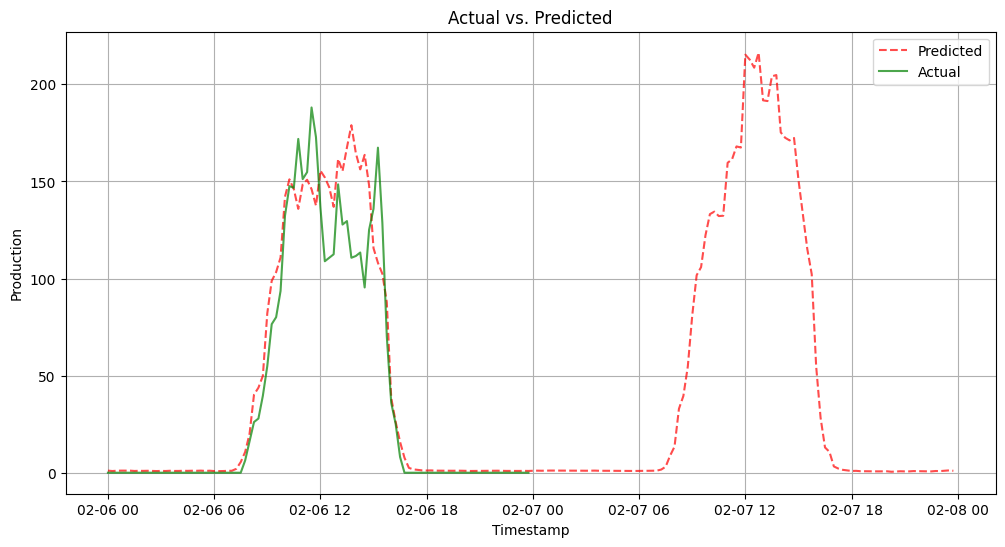

In [209]:
# Evaluate the model with known data of production for the predicted period:

start_date_val = end_date
end_date_val = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=5)
end_date_val = end_date_val.strftime('%Y-%m-%d') 


url_val = f'http://209.38.208.230:8000/api/pvmeasurementdata/?start_date={start_date_val}&end_date={end_date_val}&ppe=590310600030911897'
response_val = requests.get(url=url_val)
# Create a dataframe from the response
df_validation = pd.DataFrame(response_val.json())

df_validation['timestamp'] = pd.to_datetime(df_validation['timestamp'], errors='coerce', utc=True)

df_validation['timestamp'] = df_validation['timestamp'].dt.tz_convert('Europe/Warsaw')

df_validation['timestamp'] = df_validation['timestamp'].dt.tz_localize(None)  # Remove timezone

# prepare the prediction df
df_pred = predictions.reset_index()

plt.figure(figsize=(12, 6))

# Plot predicted mean
plt.plot(df_pred["timestamp"], df_pred["mean"], label="Predicted", linestyle='--', color="red", alpha=0.7)

plt.plot(df_validation["timestamp"], df_validation["production"], 
             label="Actual", linestyle='-', color="green", alpha=0.7)

# Optionally plot prediction intervals
plt.xlabel("Timestamp")
plt.ylabel("Production")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid()
plt.show()


In [212]:
print(df_pred[['timestamp','mean']])


              timestamp      mean
0   2025-02-06 00:00:00  1.070578
1   2025-02-06 00:15:00  0.873384
2   2025-02-06 00:30:00  1.018459
3   2025-02-06 00:45:00  1.078771
4   2025-02-06 01:00:00  1.058189
..                  ...       ...
187 2025-02-07 22:45:00  0.884316
188 2025-02-07 23:00:00  0.843993
189 2025-02-07 23:15:00  1.032271
190 2025-02-07 23:30:00  1.196080
191 2025-02-07 23:45:00  0.999230

[192 rows x 2 columns]
